# fbb skeleton notebook for PUI2017 HW6

In [1]:
from __future__ import print_function, division
#import geopandas as gp
import pandas as pd
import pylab as pl
import os
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf

#s = json.load( open(os.getenv('PUI2016')+'/fbb_matplotlibrc.json') )
#pl.rcParams.update(s)
#if os.getenv("PUIDATA") is None:
#    print ("$PUIDATA to point to set PUIdata dir")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


I am using geopanda. that is **not required** for this particular exercise, but geopanda works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!


** An interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp **

In [2]:
# Energy and Water Data sourced from
# https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z
#nrg = gp.GeoDataFrame.from_csv(os.getenv("PUIDATA") + "/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
nrg = pd.read_csv('https://raw.githubusercontent.com/sgo230/PUI2017_sgo230/master/HW6_sgo230/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv')

# Manhattan shapefiles sourced from https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page
#bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/Manhattan/MNMapPLUTO.shp")
bsize = pd.read_csv('https://raw.githubusercontent.com/sgo230/PUI2017_sgo230/master/HW6_sgo230/MN.csv')

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,22,23,25,63,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


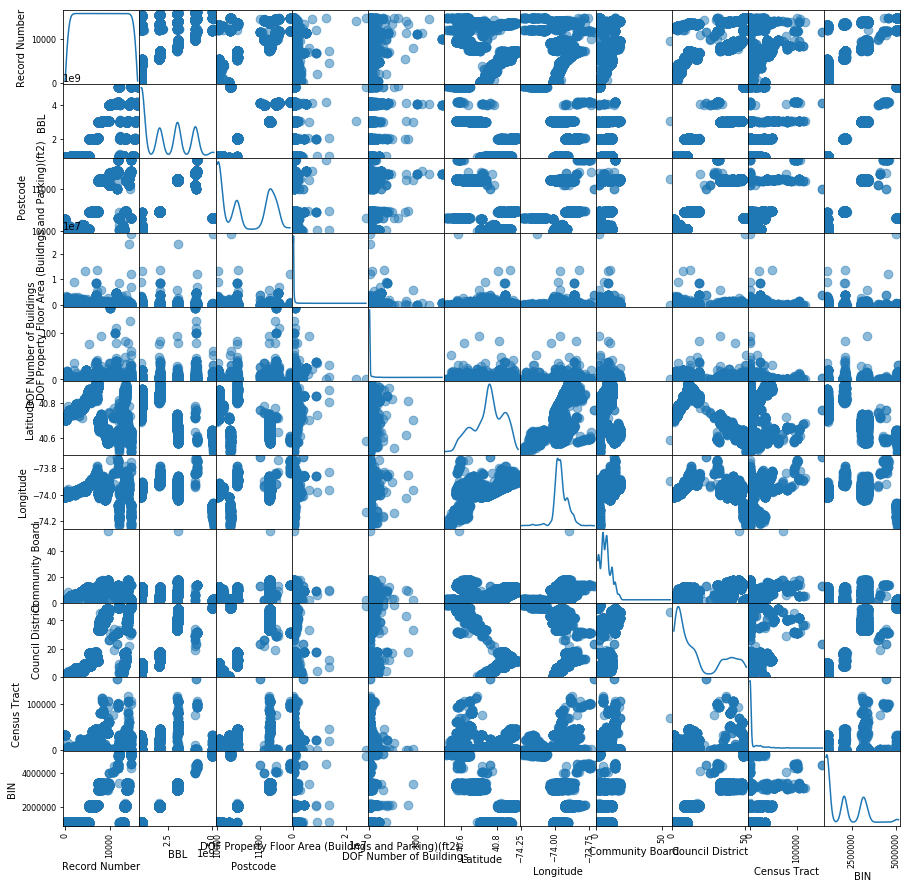

In [3]:
from pandas.tools.plotting import scatter_matrix
sfig = scatter_matrix (nrg, s=300, figsize=(15, 15), diagonal='kde')

In [4]:
nrg.columns

Index([u'Record Number', u'BBL', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Postcode',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings',
       u'Latitude', u'Longitude', u'Community Board', u'Council District',
       u'Census Tract', u'BI

In [5]:
bsize.columns

Index([u'Borough', u'Block', u'Lot', u'CD', u'CT2010', u'CB2010',
       u'SchoolDist', u'Council', u'ZipCode', u'FireComp', u'PolicePrct',
       u'HealthArea', u'SanitBoro', u'SanitDistrict', u'SanitSub', u'Address',
       u'ZoneDist1', u'ZoneDist2', u'ZoneDist3', u'ZoneDist4', u'Overlay1',
       u'Overlay2', u'SPDist1', u'SPDist2', u'SPDist3', u'LtdHeight',
       u'SplitZone', u'BldgClass', u'LandUse', u'Easements', u'OwnerType',
       u'OwnerName', u'LotArea', u'BldgArea', u'ComArea', u'ResArea',
       u'OfficeArea', u'RetailArea', u'GarageArea', u'StrgeArea',
       u'FactryArea', u'OtherArea', u'AreaSource', u'NumBldgs', u'NumFloors',
       u'UnitsRes', u'UnitsTotal', u'LotFront', u'LotDepth', u'BldgFront',
       u'BldgDepth', u'Ext', u'ProxCode', u'IrrLotCode', u'LotType',
       u'BsmtCode', u'AssessLand', u'AssessTot', u'ExemptLand', u'ExemptTot',
       u'YearBuilt', u'YearAlter1', u'YearAlter2', u'HistDist', u'Landmark',
       u'BuiltFAR', u'ResidFAR', u'CommFAR', u'

In [6]:
# Clean up for later
nrg_plot = nrg[['BBL', 'Postcode', 'DOF Property Floor Area (Buildngs and Parking)(ft2)', 'DOF Number of Buildings']]

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

## exploratory analysis

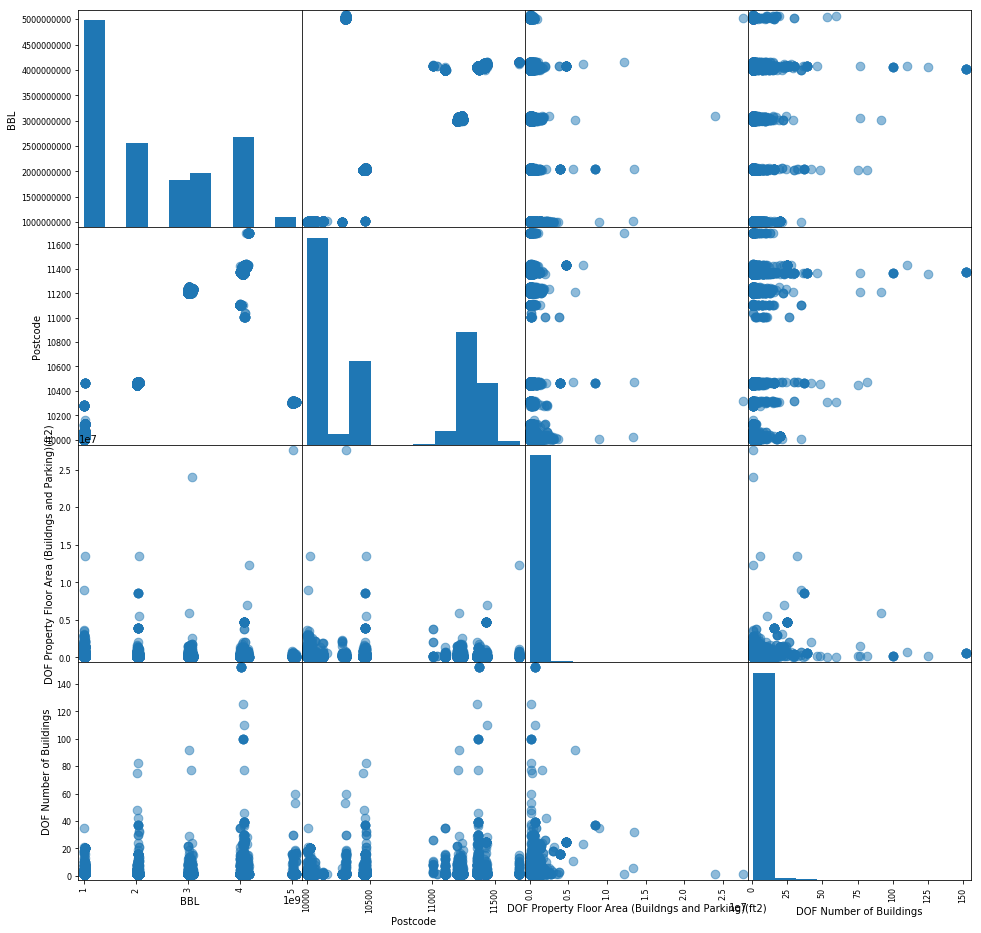

In [7]:
#try make a scatter plot of nrg. Few columns will plot - only those that have numerical values. 
#Pandas will ignore the other ones

from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg_plot, s=300, figsize=(16, 16));

<b>Figure 1</b>: Pandas scatter maxtrix of selected numerical variables. Diagonal squares down the middle are a variable plotted against itself. The only interesting pattern among the square is DOF Number of Buildings vs. DOF Property Floor Area, which has a somewhat linear negative relationship. Many square, such as Postcode vs. Number of Buildings are nonsensical since they're based on categorical data (e.g., zip code).

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, buy setting it to "coerce". Please look at the function documentation to understand the syntax.

In [8]:
# Convert columns used to numeric type
nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'], errors='coerce')
nrg['Property ft2'] = pd.to_numeric(
    nrg['Reported Property Floor Area (Building(s)) (ft²)'], errors='coerce')

In [9]:
# use pd.to_numeric to convert strings to numeric values, 
##check that your conversion worked: e.g.
print (nrg['Site EUI(kBtu/ft2)'].astype(float))
#[...] do this for all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want
print(bsize.BBL.astype(float))
#this should not return an error
#notice I can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13         NaN
14         NaN
15         NaN
16       125.4
17         NaN
18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
23         NaN
24         NaN
25         NaN
26         NaN
27         NaN
28         NaN
29         NaN
         ...  
16140      NaN
16141      NaN
16142      NaN
16143      NaN
16144      NaN
16145      NaN
16146      NaN
16147      NaN
16148      NaN
16149      NaN
16150      NaN
16151      NaN
16152      NaN
16153      NaN
16154      NaN
16155      NaN
16156      NaN
16157      NaN
16158      NaN
16159      NaN
16160      NaN
16161      NaN
16162      NaN
16163      NaN
16164      NaN
16165      NaN
16166      NaN
16167      NaN
16168      NaN
16169      NaN
Name: Site EUI(kBtu/ft2), dtype: float64
0        1.000010e+09
1        1.000010e+09


In [10]:
# Reduce dataframe to save memory; retaining only the variables used below
nrg = nrg[['BBL', 'Site EUI(kBtu/ft2)', 'Property ft2']]
bsize = bsize[['BBL', 'UnitsRes', 'UnitsTotal', 'YearBuilt']]

In [11]:
#How many missing values?
indx = np.isnan(nrg['Site EUI(kBtu/ft2)']).sum()
print ("invalid entries changed to NaN %d"%sum(indx))
#do it for however many columns you need

invalid entries changed to NaN 4623


** MERGE THE DATASETS**
look at the syntax for pandas.merge - this will be incredibly useful to you in all future data problem where you use Pandas and data aggregation is really at the heart of urban science!

TO DO IT WE NEED A COMMON COLUMN: the building id, BBL is in both files. However the name of this variable (column) in the Energy dataset is 'NYC Borough, Block, and Lot (BBL)'. 
You can rename the column, create a whole new column 'BBL' in the energy dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!). YOu can also say pd.merge(..., right_on=BBL, left_on="NYC Borough, Block, and Lot (BBL)'). Always make sure though that the data type is the same! both integers, both strings, or whatever but the same, or you will not be able to merge. 

In [12]:
# Print BBL key to test type for join below
(bsize.BBL.values[0]), (nrg.BBL.values[0])

(1000010010.0, 1000410001.0)

In [13]:
# Join dataframes on BBL and drop NaN records
bblnrgdata = pd.merge(nrg, bsize, on='BBL')#.dropna()
bblnrgdata.shape

# No need to rename further - already did so above

(6536, 6)

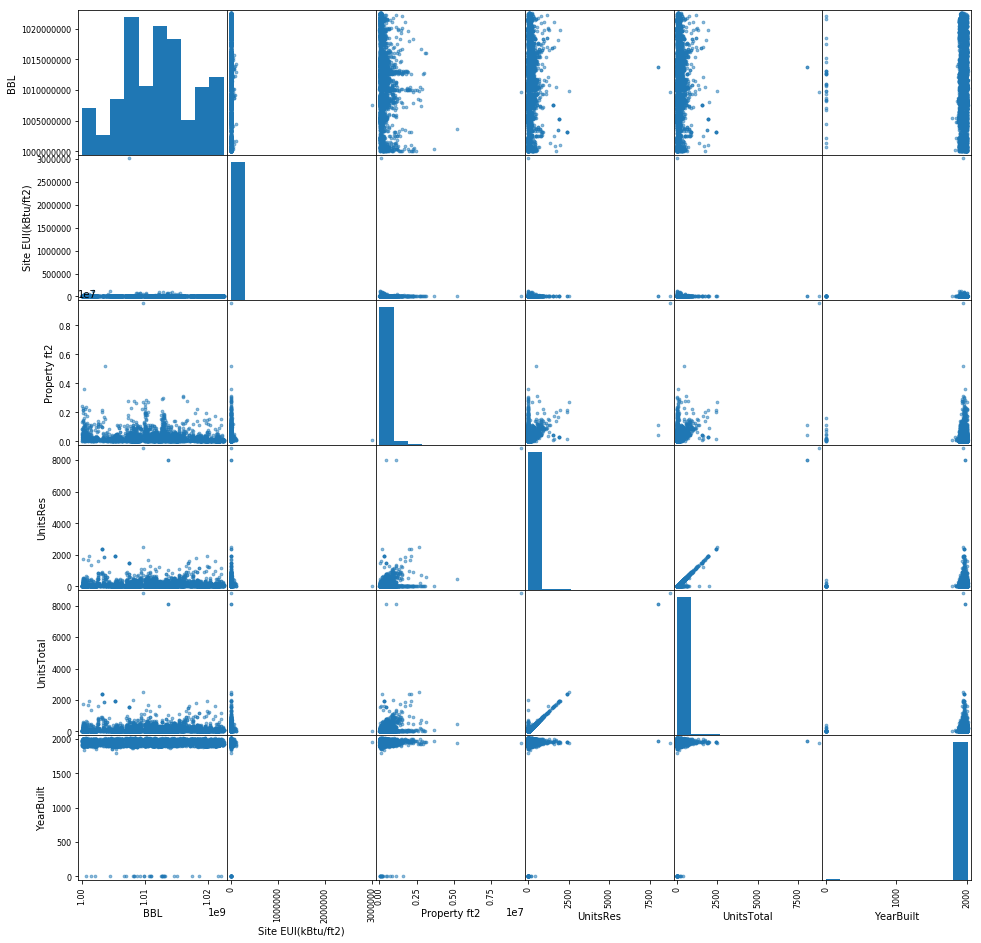

In [14]:
# Now the scatter matrix plot should show more columns.
scatter_matrix (bblnrgdata, s=30, figsize=(16, 16));

<b>Figure 2</b>: Scatter matrix of BBL, site EUI, Property Square footage, Residential Units, Total Units, and year built. Definitely need some reformatting to make these charts usable. The YearBuilt field is clustered around 1900-2000, with some 0 values. Units vs. Energy Usage show a strong correlation, but a few outliers in the data distort the view. We'll need to clean out the outliers or change the axis type. 

once you have the dataframe with all the info you want, you want to plot Energy vs Number of Units in the Building.  **Energy TOTAL, not per sq ft...** Here you can choose what you think makes more sense for the number of units: all units, residential units... 

**Make a  scatter plot first of Energy vs Units. It will look really bad be cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000. **


Make a second plot that zooms into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

I left my plots below as guidance. **Remember, each plot needs a descriptive caption, and axis labels**

In [15]:
# Multiply energy per square foot times building area and check results
bblnrgdata['nrg'] = bblnrgdata['Site EUI(kBtu/ft2)'] * bblnrgdata['Property ft2'] 
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Property ft2,UnitsRes,UnitsTotal,YearBuilt,nrg
0,1.006700e+09,NaN,NaN,0,1,1987,NaN
1,1.004370e+09,NaN,NaN,0,4,1920,NaN
2,1.013110e+09,125.4,330000.0,0,56,1977,41382000.0
3,1.009220e+09,NaN,NaN,148,148,1963,NaN
4,1.007400e+09,NaN,68329.0,0,1,1920,NaN


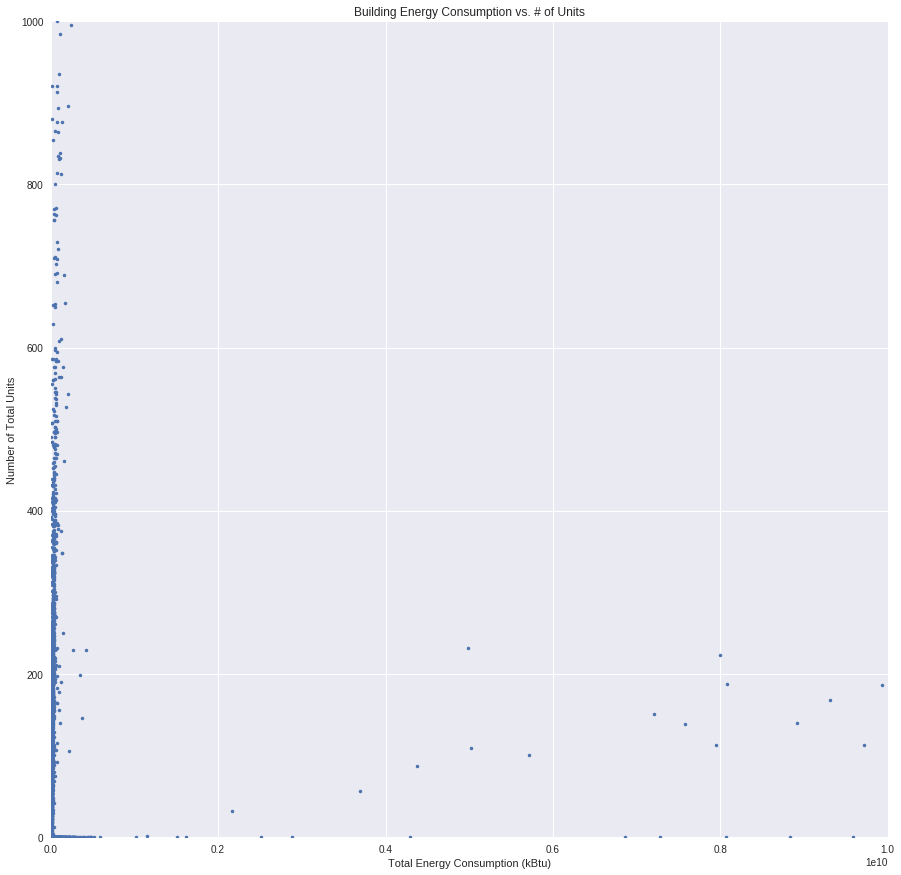

In [16]:
pl.style.use('seaborn')
pl.figure(figsize=[15,15])
pl.plot(bblnrgdata['nrg'],bblnrgdata['UnitsRes'], '.')
pl.xlim(0,1e10)
pl.ylim(0,1000)
pl.xlabel('Total Energy Consumption (kBtu)')
pl.ylabel('Number of Total Units')
pl.title('Building Energy Consumption vs. # of Units')

<b>Figure 3</b>: Initial scatter plot with total building energy consumption vs. the number of total units. Even with cutting off the x- and y-axis limits as suggested, it is hard to see any pattern or relationship without the logarithmic scale.

** IMPORTANT NOTE ABOUT LOGS AND LOG PLOTS **
in class we talked about logs when we talked about likelihood: often we prefer working with the log(likelihood) instead of the likelihood, and since all problems involving likelihood are about maximization (find the maximum likelihood to find the best fit parameters) and the log is a MONOTONIC function (log(x) grows when x grows, and gets smaller when x gets smaller) the maximum of the likelihood of a model with be in the same place as the maximum of the log(likelihood). 

Another great thing about logarithm: **when the points in a plot all look scrunched against the axis **


**Try to make a log plot instead**. In pandas you enable that with the keyword 'loglog' : bblnrgdata.plot(..... loglog=True)

This will compress the high  x and high  y values, and compress the small x and small y values. 



NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data I had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array: something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

Also I removed the buildings with several thousand units. points like that at the edge of my range would have a lot of "LEVERAGE", however they are not suprious entries like the 0, which i believe are missing values, or perhaps abandoned lots. these are good datapoint that i need to throw away functionally for my analysis to work, but that should be stated clearly.



/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


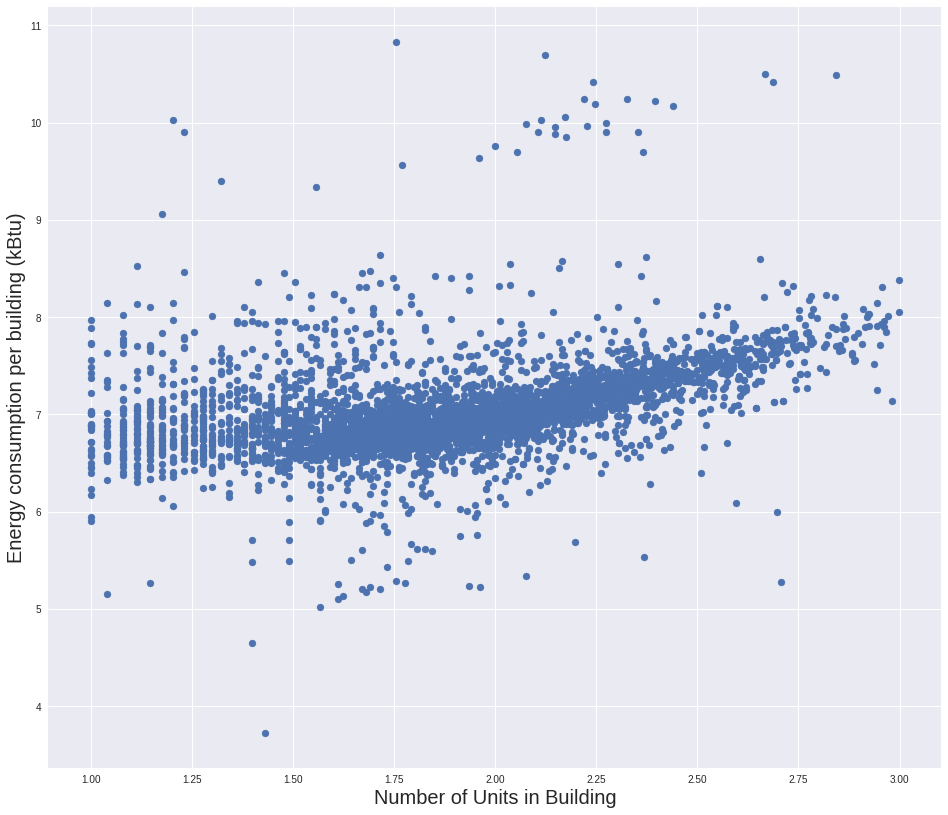

In [17]:
bblnrgdataCut = bblnrgdata[(bblnrgdata.nrg > 1000) * (bblnrgdata.UnitsTotal>=10) * 
                           (bblnrgdata.UnitsTotal<1000)]

pl.figure(figsize=[16,14])
pl.scatter(x=np.log10(bblnrgdataCut['UnitsTotal']), y=np.log10(bblnrgdataCut['nrg']))
pl.xlabel("Number of Units in Building", fontsize=20)
pl.ylabel("Energy consumption per building (kBtu)", fontsize=20)

<b>Figure 4</b>: Log scale helps significantly in viewing the results. Moderate correlation between the number of units and the energy consumption, as expected. There are still a few reasonable outliers, but the bulk of data points fit nicely between energy usage of 1000000 and 100000000 kBtu (10e6-10e8).

Now fit a line through the data. you can use whatever you want to do it: statsmodels, scipy, any other package, or write your own minimization of the residuals

## BUT REMEMBER: we see hints of a linear relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:
if you used statsmodels it would look something like this:


In [18]:
# Create OLS model
X = sm.add_constant(np.log10(bblnrgdataCut['UnitsTotal']))
linmodel = sm.OLS(np.log10(bblnrgdataCut['nrg']), X, missing='drop').fit()
lm = linmodel.fittedvalues

In [19]:
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    nrg   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     827.0
Date:                Sun, 26 Nov 2017   Prob (F-statistic):          1.93e-166
Time:                        16:43:57   Log-Likelihood:                -2605.2
No. Observations:                4285   AIC:                             5214.
Df Residuals:                    4283   BIC:                             5227.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.1089      0.033    186.025      0.000         6.045     6.173
UnitsTotal     0.4904      0.017     28.758      0.000         0.457     0.524
==============================================================================
Omnibus:                     2272.854   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43917.184
Skew:                           2.095   Prob(JB):                         0.00
Kurtosis:                      18.114   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

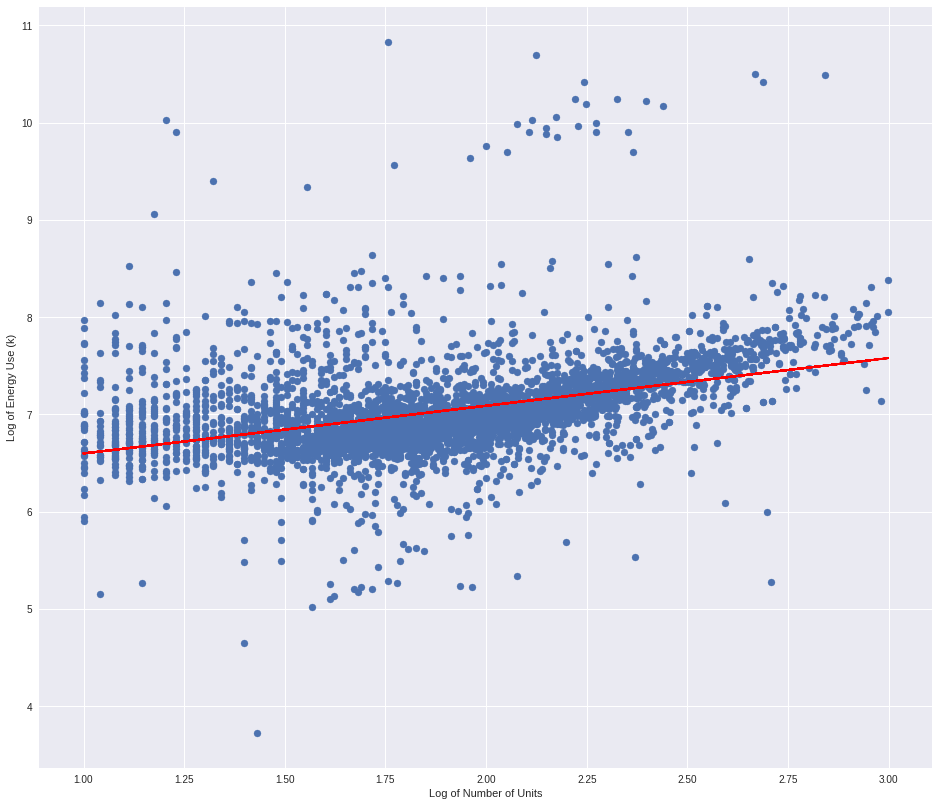

In [20]:
# Plot OLS line and scatter plot
pl.figure(figsize=[16,14])
pl.plot(np.log10(bblnrgdataCut['UnitsTotal']), lm, color='red')
pl.scatter(x=np.log10(bblnrgdataCut['UnitsTotal']), y=np.log10(bblnrgdataCut['nrg']))
pl.xlabel('Log of Number of Units')
pl.ylabel('Log of Energy Use (k)')

<b>Figure 5</b>: Scatter chart with OLS line showing moderate positive linear correlation

In [21]:
# Create OLS model for opposite - energy vs. units
X_2 = sm.add_constant(np.log10(bblnrgdataCut['nrg']))
linmodel_2 = sm.OLS(np.log10(bblnrgdataCut['UnitsTotal']), X_2, missing='drop').fit()
lm_2 = linmodel_2.fittedvalues

In [22]:
linmodel_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     827.0
Date:                Sun, 26 Nov 2017   Prob (F-statistic):          1.93e-166
Time:                        16:43:58   Log-Likelihood:                -1756.8
No. Observations:                4285   AIC:                             3518.
Df Residuals:                    4283   BIC:                             3530.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.4369      0.081     -5.400      0.000        -0.596    -0.278
nrg            0.3300      0.011     28.758      0.000         0.308     0.353
==============================================================================
Omnibus:                      144.802   Durbin-Watson:                   1.387
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.337
Skew:                          -0.457   Prob(JB):                     2.51e-35
Kurtosis:                       3.241   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

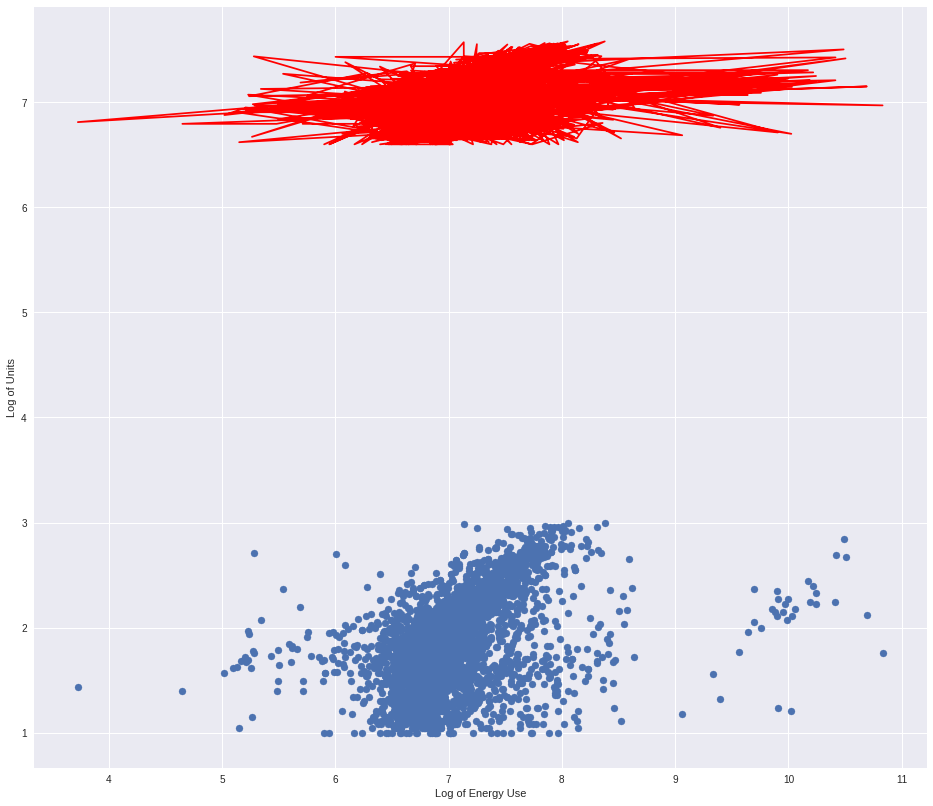

In [23]:
# Plot OLS line and scatter plot
pl.figure(figsize=[16,14])
pl.plot(np.log10(bblnrgdataCut['nrg']), lm, color='red')
pl.scatter(x=np.log10(bblnrgdataCut['nrg']), y=np.log10(bblnrgdataCut['UnitsTotal']))
pl.xlabel('Log of Energy Use')
pl.ylabel('Log of Units')

In [24]:
# Generate errors using Federica's samples
errorsnrg = np.sqrt((bblnrgdataCut['Property ft2'])**2 +\
                (bblnrgdataCut['Site EUI(kBtu/ft2)']**2))
errorsunits = np.sqrt(bblnrgdataCut.UnitsTotal)

#Log errors
errorsInLogNrg = np.abs(errorsnrg / bblnrgdataCut.nrg / np.log(10))
errorsInLogUnits = np.abs(errorsunits / bblnrgdataCut.UnitsTotal / np.log(10))

bblnrgdataCut['errorsnrg'] = errorsInLogNrg
bblnrgdataCut['errorsunits'] = errorsInLogUnits

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1

In [26]:
print("Units vs. energy chi-square statistic: {:.2f}"\
      .format(chi2(np.log10(bblnrgdataCut['UnitsTotal']), lm, bblnrgdataCut['errorsunits'])))
print("Energy vs. units chi-square statistic: {:.2f}"\
      .format(chi2(np.log10(bblnrgdataCut['nrg']), lm_2, bblnrgdataCut['errorsnrg'])))
print("\nObviously, Units vs. energy is lower, as expected")

Units vs. energy chi-square statistic: 65564901.90
Energy vs. units chi-square statistic: 21515113771706.55

Obviously, Units vs. energy is lower, as expected


In [27]:
# Create mini dataframe for Statsmodels.Formula.API model
df_ = bblnrgdataCut[['nrg', 'UnitsTotal']]

# Define quadratic model
qm = smf.ols("nrg ~ UnitsTotal + I(UnitsTotal**2)", data = df_).fit()

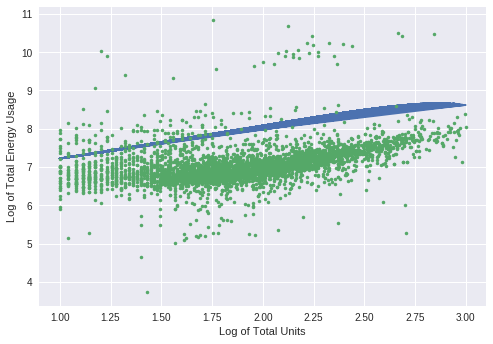

In [28]:
# Plot with polynomial model
qm_fit = qm.fittedvalues
pl.plot(np.log10(df_['UnitsTotal']), np.log10(qm_fit), '-')
pl.plot(np.log10(df_['UnitsTotal']), np.log10(df_['nrg']),'.')
pl.xlabel('Log of Total Units')
pl.ylabel('Log of Total Energy Usage')

<b>Null hypothesis:</b> The polynomial (more complicated) model overfits the data compared to the simpler (linear) model. Significance level: 0.05.

In [29]:
# Get test parameters
qm.compare_lr_test(linmodel)

(-189233.79787262704, 1.0, 1.0)

Because the p-value of 1.0 exceeds our significance level of alpha = 0.5, we do not reject the null hypothesis that the polynomial model overfits the data compared to our earlier simpler linear model.

## ASH - Score 100 (Extra Credit Missing)